In [1]:
import json
import os
import torch
from torch import nn, optim
from tqdm import tqdm
import torch.nn.functional as F
import matplotlib.pyplot as plt
import numpy as np
from torchvision import datasets, transforms
from torch.utils.data import TensorDataset, DataLoader

device = 'cuda' if torch.cuda.is_available() else 'cpu'
print(device)

cpu


In [2]:
def read_json_file(filename):
    with open(filename, 'r') as file:
        data = json.load(file)
    return data

In [53]:
# Initialize lists to store integrated segments (X) and labels (y)
X = []
y = []

In [54]:
# Define the filename
filename = "Jinghao_ECG_2.json"

# Read the JSON file
data = read_json_file(filename)

# Extract integrated segments and labels from the data
for segment_data in data:
    integrated_segment = segment_data["integrated_segment"]
    label = segment_data["label"]
    X.append(integrated_segment)
    y.append(label)

In [55]:
# prompt: check the maximum length of the lists in X

max_length = max(len(lst) for lst in X)
print(max_length)


689


In [56]:
max_length = 1000

In [57]:
padded_X = []
for segment in X:
    pad_length = max_length - len(segment)
    padded_segment = np.pad(segment, (0, pad_length), mode='edge')  # Padding with the last observed value
    padded_X.append(padded_segment)
# Convert padded_X to a numpy array
padded_X = np.array(padded_X)

# Print the shape of padded_X to verify
print("Shape of padded_X:", padded_X.shape)

Shape of padded_X: (2794, 1000)


In [58]:
class FCClassifier(nn.Module):
    def __init__(self, input_dim):
        super(FCClassifier, self).__init__()
        self.fc1 = nn.Linear(input_dim, 512)
        self.fc2 = nn.Linear(512, 256)
        self.fc3 = nn.Linear(256, 128)
        self.fc4 = nn.Linear(128, 2)
        self.dropout = nn.Dropout(0.5)
        self.non_lin = nn.LeakyReLU(0.2)

    def forward(self, x):
        x = self.non_lin(self.fc1(x))
        x = self.dropout(x)
        x = self.non_lin(self.fc2(x))
        x = self.dropout(x)
        x = self.non_lin(self.fc3(x))
        x = self.dropout(x)
        x = torch.sigmoid(self.fc4(x))
        return x

In [59]:
model = FCClassifier(input_dim=max_length).to(device)

In [79]:
model.load_state_dict(torch.load('Jinghao_fc1000_hif1.pth', map_location=device))

<All keys matched successfully>

In [80]:
aX = torch.tensor(padded_X, dtype=torch.float32).to(device)
ay = torch.tensor(y, dtype=torch.float32).view(-1, 1).to(device)

In [81]:
dataset_30 = TensorDataset(aX, ay)
test_loader = DataLoader(dataset_30, batch_size=30, shuffle=False)

In [82]:
from sklearn.utils.class_weight import compute_class_weight

# Calculate class weights
class_weights = compute_class_weight('balanced', classes=np.unique(np.array([0, 1])), y=y)
class_weights = torch.tensor(class_weights, dtype=torch.float32).to(device)
print(class_weights)

tensor([1.3563, 0.7920])


In [83]:
from torch.optim import lr_scheduler
criterion = nn.CrossEntropyLoss(weight=class_weights)

In [86]:
from tqdm import tqdm
from sklearn.metrics import f1_score
model.eval()
running_val_loss = 0.0
correct_val = 0
total_val = 0
val_predictions = []
val_labels = []

with torch.no_grad():
    for inputs, labels in test_loader:
        outputs = model(inputs)
        labels_onehot = F.one_hot(labels.long(), num_classes=2).squeeze(1).type(torch.float32)
        loss = criterion(outputs, labels_onehot)
        running_val_loss += loss.item()

        # Compute validation accuracy
        prediction = torch.argmax(outputs, dim=1).cpu().detach().numpy()
        expected = torch.argmax(labels_onehot, dim=1).cpu().detach().numpy()
        print(prediction, expected)
        if np.sum(prediction) > 20:
            predict = 1
        else:
            predict = 0
        

        if np.sum(expected) > 10:
            actual = 1
        else:
            actual = 0
        
        print('Prediction:', predict, 'Expected:', actual)
        correct_val = correct_val + 1 if predict == actual else correct_val
        total_val += 1
        val_predictions.append(predict)
        val_labels.append(actual)
    print('Accuracy over 30 ticks:', correct_val / total_val * 100.0, correct_val, total_val)
    print('F1 score,', f1_score(val_labels, val_predictions))

[0 1 1 1 0 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 0 1 1 1 0 0 1] [1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1]
Prediction: 1 Expected: 1
[1 1 0 1 1 1 1 1 0 1 0 0 0 0 0 0 0 1 1 0 1 1 0 1 1 1 1 1 1 1] [1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1]
Prediction: 0 Expected: 1
[0 1 0 1 0 0 1 1 1 1 1 0 1 1 1 1 0 1 1 1 1 1 1 1 1 1 1 1 1 1] [1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1]
Prediction: 1 Expected: 1
[0 1 0 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1] [1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1]
Prediction: 1 Expected: 1
[1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 0 1 1 1 1 1 1 1 1 0 0 0] [1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1]
Prediction: 1 Expected: 1
[1 1 1 0 0 1 1 1 1 0 1 1 1 0 1 1 1 1 1 1 1 1 0 1 0 1 0 1 1 1] [1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1]
Prediction: 1 Expected: 1
[1 1 1 1 1 1 1 1 1 1 1 0 1 1 1 1 1 1 1 0 1 0 1 1 1 1 1 1 1 1] [1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1

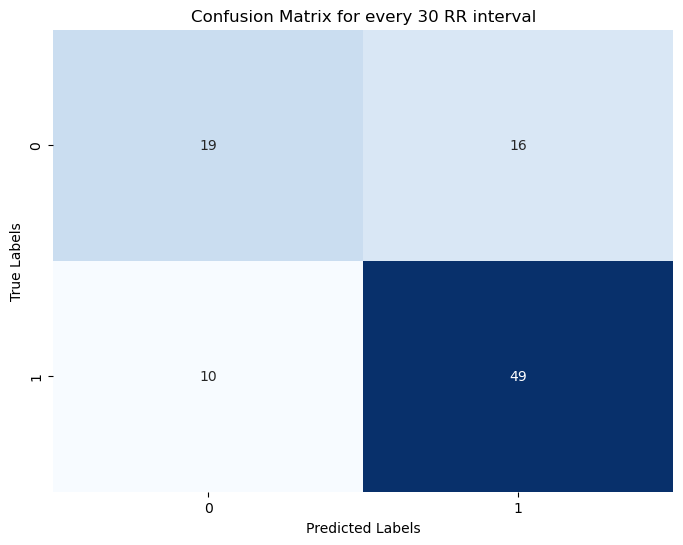

In [87]:
from sklearn.metrics import confusion_matrix
import matplotlib.pyplot as plt
import seaborn as sns
conf_matrix = confusion_matrix(val_labels, val_predictions)
plt.figure(figsize=(8, 6))
sns.heatmap(conf_matrix, annot=True, cmap='Blues', fmt='d', cbar=False)
plt.xlabel('Predicted Labels')
plt.ylabel('True Labels')
plt.title('Confusion Matrix for every 30 RR interval')
plt.show()